# Boot up

In [21]:
# load libraies or connect API
import numpy as np
import pandas as pd
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import sent_tokenize,word_tokenize
from collections import Counter
import gensim
from gensim import corpora
import pyLDAvis.gensim
import nltk
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import re

In [22]:
# Load the data
path = ''
file = ''
day1 = pd.read_csv(path+file, skiprows = 8, usecols = ['Transcript','Transaction Exists'])
day1.head()

,Transcript,Transaction Exists
0,05:25:48 info: Thank you for choosing to chat ...,False
1,05:23:25 info: Thank you for choosing to chat ...,False
2,05:21:56 info: Thank you for choosing to chat ...,False
3,05:20:59 info: Thank you for choosing to chat ...,False
4,05:19:41 info: Thank you for choosing to chat ...,False


# Text proprocessing

In [23]:
# Tokenize text to sentences
day1["sent_token"] = day1.Transcript.apply(sent_tokenize)

In [24]:
day1['idx'] = day1.sent_token.apply(lambda sents: ['You are now chatting with' in i for i in sents].index(True))

In [25]:
day1['Content'] = day1.apply(lambda row: " ".join([ j for i,j in enumerate(row.sent_token) if (i > row.idx)]), axis = 1)

In [26]:
# define stopwords and lemmatize words
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
extra = ("to","cc","subject","http","from","sent", "ect", "u", "fwd", "www", "com",'thank',"u","choosing", 
         "chat","shortly","agent","assisting","info","yes","hello","sleep","number","span")
stop.update(extra)
#stop.update(names)
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

In [27]:
# define a function to process text
def clean(text, stop):
    text = re.sub('(\d+:\d+:\d+)', '', str(text))
    text = text.rstrip()
    #name_free = " ".join([i for i in text.split() if i not in names])
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(i for i in stop_free if i not in exclude)
    normalized = " ".join(lemma.lemmatize(i) for i in punc_free.split()) 
    digit_free = " ".join([i for i in normalized.split() if((i not in stop) and (not i.isdigit()))])     
    return digit_free

<input>:3: DeprecationWarning: invalid escape sequence \d
<input>:3: DeprecationWarning: invalid escape sequence \d
<input>:3: DeprecationWarning: invalid escape sequence \d
<ipython-input-27-97acdda03c5a>:3: DeprecationWarning: invalid escape sequence \d
  text = re.sub('(\d+:\d+:\d+)', '', str(text))


In [28]:
text = day1.Transcript[4]
stop_free = " ".join([word for word in text.split() if word not in stop])
digit_free = " ".join([word for word in stop_free.split() if not word.isdigit()])
[i for i in digit_free.split() if i.isdigit()]

[]

In [29]:
text_clean=[]
for text in day1['Content']:
    text_clean.append(clean(text, stop).split())    
print(text_clean[2])

['keith', 'smith', 'crystal', 'spanthank', 'visiting', 'name', 'crystal', 'number®', 'setting', 'may', 'assist', 'youspan', 'keith', 'smith', 'air', 'pressure', 'controlled', 'keith', 'smith', 'keith', 'smith', 'anybody', 'crystal', 'keith', 'apology', 'wait', 'air', 'pressure', 'controlled', 'pump', 'keith', 'smith', 'control', 'pump', 'keith', 'smith', 'wired', 'wireless', 'controller', 'crystal', 'one', 'moment', 'get', 'information', 'crystal', 'apology', 'keith', 'took', 'look', 'could', 'find', 'specific', 'information', 'may', 'proprietary', 'give', 'call', 'see', 'somebody', 'could', 'give', 'information', 'keith', 'smith', 'never', 'mind', 'keith', 'smith', 'good', 'bye']


In [30]:
def clean_with_stop(text):
    return clean(text, stop)
day1['wordlist'] = day1.Content.apply(clean_with_stop)

In [31]:
day1.head()

,Transcript,Transaction Exists,sent_token,idx,Content,wordlist
0,05:25:48 info: Thank you for choosing to chat ...,False,[05:25:48 info: Thank you for choosing to chat...,5,05:28:06 info: \r\n05:28:06 info: \r\n05:28:13...,michael x12 king need order sheet don’t know n...
1,05:23:25 info: Thank you for choosing to chat ...,False,[05:23:25 info: Thank you for choosing to chat...,2,05:25:28 Brian: <span>Thank you for visiting S...,brian spanthank visiting name brian number® se...
2,05:21:56 info: Thank you for choosing to chat ...,False,[05:21:56 info: Thank you for choosing to chat...,2,05:22:59 Keith Smith: Hello\r\n05:22:59 Crysta...,keith smith crystal spanthank visiting name cr...
3,05:20:59 info: Thank you for choosing to chat ...,False,[05:20:59 info: Thank you for choosing to chat...,2,05:21:00 info: \r\n05:21:09 Crystal: <span>Tha...,crystal spanthank visiting name crystal number...
4,05:19:41 info: Thank you for choosing to chat ...,False,[05:19:41 info: Thank you for choosing to chat...,2,05:20:24 info: \r\n05:20:24 info: \r\n05:20:27...,mark spanthank visiting name mark number® sett...


In [32]:
day1.to_csv('day20190131_clean.csv')

# LDA

In [33]:
dictionary = corpora.Dictionary(text_clean)
corpus = [dictionary.doc2bow(text) for text in text_clean]

In [34]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=5)

topics = ldamodel.print_topics(num_words=5)

for topic in topics:
    print(topic)

(0, '0.036*"angela" + 0.023*"mike" + 0.017*"visiting" + 0.015*"bed" + 0.012*"teddy"')
(1, '0.019*"brenda" + 0.014*"teddy" + 0.013*"visiting" + 0.012*"torus" + 0.011*"bed"')
(2, '0.017*"aaron" + 0.014*"max" + 0.013*"bed" + 0.013*"julie" + 0.012*"base"')
(3, '0.030*"tony" + 0.015*"form" + 0.013*"vlad" + 0.011*"visiting" + 0.011*"jamason"')
(4, '0.017*"bed" + 0.012*"aaron" + 0.010*"julie" + 0.010*"christopher" + 0.008*"may"')


In [35]:
def get_topic_details(ldamodel, corpus):
    topic_details_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_details_df = topic_details_df.append(pd.Series([topic_num, prop_topic]), ignore_index=True)
    topic_details_df.columns = ['Dominant_Topic', '% Score']
    return topic_details_df

In [36]:
day_with_cluster = pd.concat([day1, get_topic_details(ldamodel, corpus)], axis=1, sort=False)

In [37]:
day_with_cluster.to_csv('day20190131_with_cluster.csv')

In [38]:
contents = pd.DataFrame({'Original text': text_clean})
topic_details = pd.concat([get_topic_details(ldamodel, corpus), contents], axis=1)
topic_details.head()

,Dominant_Topic,% Score,Original text
0,3.0,0.774483,"[michael, x12, king, need, order, sheet, don’t..."
1,0.0,0.704739,"[brian, spanthank, visiting, name, brian, numb..."
2,4.0,0.988537,"[keith, smith, crystal, spanthank, visiting, n..."
3,4.0,0.992099,"[crystal, spanthank, visiting, name, crystal, ..."
4,3.0,0.868073,"[mark, spanthank, visiting, name, mark, number..."


In [39]:
contents = pd.DataFrame({'Original text':text_clean})
topic_details = pd.concat([get_topic_details(ldamodel, corpus), contents], axis=1)

topic_details['flag'] = np.where((topic_details['Dominant_Topic'] == 3.0), 1, 0)
print(topic_details.head())

   Dominant_Topic   % Score  \
0             3.0  0.772819   
1             0.0  0.704739   
2             4.0  0.988537   
3             4.0  0.992102   
4             3.0  0.867576   

                                       Original text  flag  
0  [michael, x12, king, need, order, sheet, don’t...     1  
1  [brian, spanthank, visiting, name, brian, numb...     0  
2  [keith, smith, crystal, spanthank, visiting, n...     0  
3  [crystal, spanthank, visiting, name, crystal, ...     0  
4  [mark, spanthank, visiting, name, mark, number...     1  


In [40]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics = True)
pyLDAvis.display(lda_display)

C:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [41]:
ldamodel.save('ldamodel5.model')
ldamodel = gensim.models.ldamodel.LdaModel.load('ldamodel5.model')

# NER

In [42]:
articles = ' '.join(day1.Content.tolist())

In [43]:
sents = sent_tokenize(articles)
words = [word_tokenize(sent) for sent in sents]

In [44]:
from nltk.corpus import stopwords
english_stops = set(stopwords.words('english'))
english_stops.update(("to","u","span","cc","subject","http","from","sent", "ect", "fwd", "www", "com","thank"))

lower_tokens = [[t.lower() for t in sent] for sent in words]
alpha_only = [[t for t in sent if t.isalpha()] for sent in lower_tokens]
no_stops = [[t for t in sent if t not in english_stops] for sent in alpha_only]
# Instantiate the WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Lemmatize all tokens into a new list: lemmatized
lemmatized = [[wordnet_lemmatizer.lemmatize(t) for t in sent] for sent in no_stops]

In [45]:
# Import Dictionary
from gensim.corpora.dictionary import Dictionary

# Create a Dictionary from the articles: dictionary
dictionary = Dictionary(lemmatized)
# Create a MmCorpus: corpus
corpus = [dictionary.doc2bow(article) for article in lemmatized]

# Print the first 10 word ids with their frequency counts from the fifth document
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 2), (7, 2), (8, 2), (9, 1), (10, 1)]


In [46]:
from collections import defaultdict
import itertools

# Save the second document: doc
doc = corpus[0]

# Sort the doc for frequency: bow_doc
bow_doc = sorted(doc, key=lambda w: w[1], reverse=True)

# Print the top 5 words of the document alongside the count
#for word_id, word_count in bow_doc[:5]:
#    print(dictionary.get(word_id), word_count)

# Create the defaultdict: total_word_count
total_word_count = defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(corpus):
    total_word_count[word_id] += word_count

# Create a sorted list from the defaultdict: sorted_word_count
sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True) 

# Print the top 5 words across all documents alongside the count
for word, word_count in sorted_word_count[:5]:
    print(dictionary.get(word), word_count)

sleep 3895
bed 2418
visiting 2129
number 1965
info 1722


In [47]:
# Import TfidfModel
from gensim.models.tfidfmodel import TfidfModel

# Create a new TfidfModel using the corpus: tfidf
tfidf = TfidfModel(corpus)

# Calculate the tfidf weights of doc: tfidf_weights
tfidf_weights = tfidf[doc]

# Print the first five weights
print(tfidf_weights[:5])
print('\n\n')


# Sort the weights from highest to lowest: sorted_tfidf_weights
sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)

# Print the top 5 weighted words
for term_id, weight in sorted_tfidf_weights[:5]:
    print(dictionary.get(term_id), weight)

[(0, 0.2767702600159976), (1, 0.2588908920592622), (2, 0.20382508035720387), (3, 0.28226997597210307), (4, 0.17691966416313293)]



michael 0.6216405881466986
need 0.3191584986884513
order 0.31484396874888315
info 0.28226997597210307
crystal 0.2767702600159976


In [68]:
# Tokenize the article into sentences: sentences
sentences = nltk.sent_tokenize(articles)

# Tokenize each sentence into words: token_sentences
token_sentences = [nltk.word_tokenize(sent) for sent in sentences]

# Tag each tokenized sentence into parts of speech: pos_sentences
pos_sentences = [nltk.pos_tag(sent) for sent in token_sentences] 

# Create the named entity chunks: chunked_sentences
chunked_sentences = nltk.ne_chunk_sents(pos_sentences, binary = True)

# Test for stems of the tree with 'NE' tags
count = 0
for sent in chunked_sentences:
    for chunk in sent:
        if hasattr(chunk, "label") and chunk.label() == "NE":
            count += 1
            print(chunk)
    if count == 10:
        break

(NE X12/NNP)
(NE Flextop/NNP King/NNP)
(NE Michael/NNP)
(NE Brian/JJ)
(NE Sleep/NNP Number/NNP)
(NE Brian/NNP)
(NE Brian/NNP)
(NE Brian/JJ)
(NE Please/NNP)
(NE Sleep/NNP Number/NNP)


In [49]:
import matplotlib.pyplot as plt

# Create the defaultdict: ner_categories
ner_categories = defaultdict(int)

chunked_sentences = nltk.ne_chunk_sents(pos_sentences)

# Create the nested for loop
for sent in chunked_sentences:
    for chunk in sent:
        if hasattr(chunk, 'label'):
            ner_categories[chunk.label()] += 1
            
# Create a list from the dictionary keys for the chart labels: labels
labels = list(ner_categories.keys())

print(labels)

# Create a list of the values: values
values = [ner_categories.get(l) for l in labels]

['PERSON', 'ORGANIZATION', 'GPE', 'FACILITY', 'GSP', 'LOCATION']


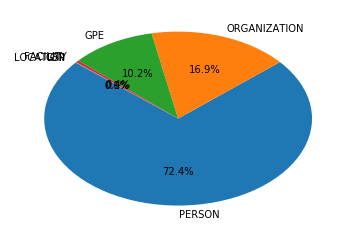

In [50]:
# Display the chart
# Create the pie chart
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.show()

In [69]:
# Import spacy
import spacy

# Instantiate the English model: nlp
nlp = spacy.load('en',tagger = False,parser=False, matcher=False)

# Create a new document: doc
doc = nlp(articles[:99999])

names = list()
# Print all of the found entities and their labels
for ent in doc.ents:
    if ent.label_ == 'PERSON':
        names.append(ent.text)
#    print(ent.label_, ent.text)

#for ent in doc.ents:
#    print(ent.label_)
#    break

In [53]:
# Create a series to store the labels: y
y = day1["Transaction Exists"]

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(day1.Transcript, y, test_size = 0.33, random_state = 53)

# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words='english')

# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(X_test)

# Print the first 10 features of the count_vectorizer
print(count_vectorizer.get_feature_names()[:10])

['00', '000', '0000', '0063', '00am', '00estimated', '00pm', '00you', '01', '0119']


In [54]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english',max_df=0.7)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

# Print the first 10 features
print(tfidf_vectorizer.get_feature_names()[:10],'\n\n')

# Print the first 5 vectors of the tfidf training data
print(tfidf_train[1])

['00', '000', '0000', '0063', '00am', '00estimated', '00pm', '00you', '01', '0119'] 


  (0, 284)	0.01123202227119435
  (0, 363)	0.05710183394350823
  (0, 39)	0.011306676543397022
  (0, 446)	0.01104921810924109
  (0, 498)	0.011674071134292115
  (0, 2561)	0.043595027316368815
  (0, 135)	0.011158254124044628
  (0, 13)	0.02284073357740329
  (0, 177)	0.2753323442431969
  (0, 348)	0.04783758014141198
  (0, 1073)	0.36205508344213816
  (0, 430)	0.023835647373667106
  (0, 311)	0.009680445059904882
  (0, 420)	0.012001246327721997
  (0, 549)	0.011835506014110726
  (0, 3391)	0.013845403513388607
  (0, 4268)	0.5425077308382008
  (0, 3392)	0.03194435423450073
  (0, 0)	0.021466276932115724
  (0, 1215)	0.3648461906256254
  (0, 3162)	0.36230629765785727
  (0, 6720)	0.038750552202728626
  (0, 5145)	0.03053598051523528
  (0, 4591)	0.01639363986459376
  (0, 1497)	0.09167442592110353
  :	:
  (0, 6403)	0.035272599718319635
  (0, 806)	0.04305838806201238
  (0, 2141)	0.035272599718319635
  (0, 1084)	0.035272

In [55]:
len(count_train.A[0])

7135

In [56]:
# Create the CountVectorizer DataFrame: count_df
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())

# Create the TfidfVectorizer DataFrame: tfidf_df
tfidf_df = pd.DataFrame(tfidf_train.A,columns = tfidf_vectorizer.get_feature_names())

In [57]:
# Import the necessary modules
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB

# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(count_train,y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(count_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)

0.9756756756756757


In [58]:
# Create a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(tfidf_train,y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(tfidf_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test,pred)
print(score)

# Calculate the confusion matrix: cm
#cm = metrics.confusion_matrix(y_test,pred, labels = ['FAKE','REAL'])
#print(cm)

0.9756756756756757


In [59]:
import numpy as np
# Create the list of alphas: alphas
alphas = np.arange(0,1,0.1)

# Define train_and_predict()
def train_and_predict(alpha):
    # Instantiate the classifier: nb_classifier
    nb_classifier = MultinomialNB(alpha) # Alpha: additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).
    # Fit to the training data
    nb_classifier.fit(tfidf_train,y_train)
    # Predict the labels: pred
    pred = nb_classifier.predict(tfidf_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test, pred)
    return score

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha),'\n')

Alpha:  0.0


C:\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Score:  0.9783783783783784 

Alpha:  0.1
Score:  0.9756756756756757 

Alpha:  0.2
Score:  0.9756756756756757 

Alpha:  0.30000000000000004
Score:  0.9756756756756757 

Alpha:  0.4
Score:  0.9756756756756757 

Alpha:  0.5
Score:  0.9756756756756757 

Alpha:  0.6000000000000001
Score:  0.9756756756756757 

Alpha:  0.7000000000000001
Score:  0.9756756756756757 

Alpha:  0.8
Score:  0.9756756756756757 

Alpha:  0.9
Score:  0.9756756756756757 



# Wordcloud

In [60]:
# Save the second document: doc
word_freq = [j for i in corpus for j in i]

In [61]:
# Sort the doc for frequency:
bow_articles = sorted(word_freq, key=lambda w: w[1], reverse=True)

# Create the defaultdict: total_word_count
total_word_count = defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(corpus):
    total_word_count[word_id] += word_count

# Create a sorted list from the defaultdict: sorted_word_count
sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True) 

In [62]:
sorted_word_count_words = list()
for word, word_count in sorted_word_count:
    sorted_word_count_words.append((dictionary.get(word), word_count))

In [63]:
words = [i[0] for i in sorted_word_count_words]

In [64]:
freq = [i[1] for i in sorted_word_count_words]

In [65]:
pd.DataFrame(words,freq).to_csv('wordcloud_data.csv')

<BarContainer object of 8 artists>

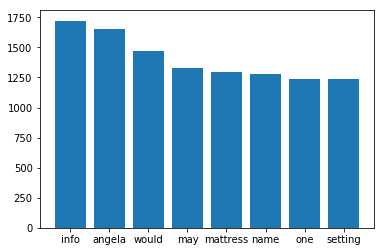

In [66]:
plt.bar(words[4:12], freq[4:12])